In [8]:
import pandas as pd
import numpy as np

In [9]:
df_all = []

for idx in df_partitions[df_partitions.Proposal != 'test'].Id:
    df_all.append(get_subject_label(idx))

df_all = pd.concat(df_all)

<Axes: >

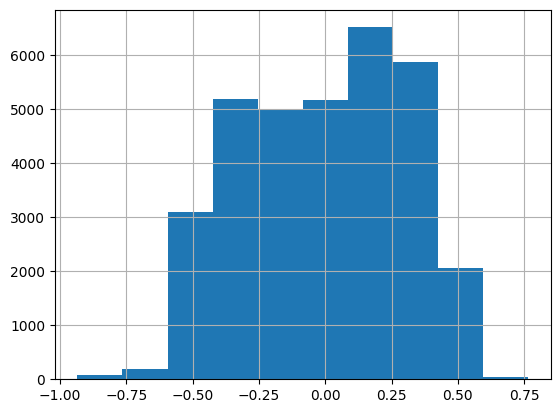

In [10]:
df_all.arousal.hist()

<Axes: >

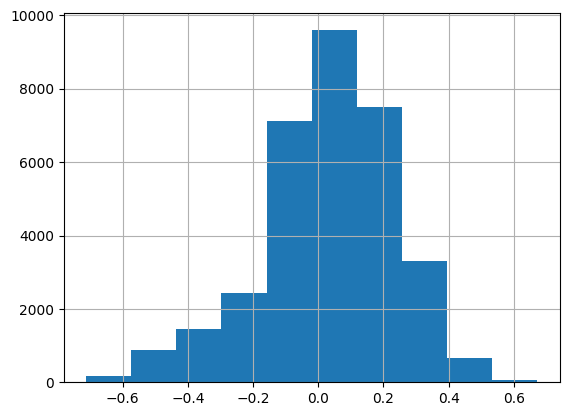

In [11]:
df_all.valence.hist()

In [12]:
import pandas as pd
import numpy as np

def get_subject_label(subject):
    df_arousal = pd.read_csv(f'c3_muse_stress/label_segments/arousal/{subject}.csv')
    df_arousal.columns = ['timestamp', 'segment_id', 'arousal']
    df_valence = pd.read_csv(f'c3_muse_stress/label_segments/valence/{subject}.csv')
    df_valence.columns = ['timestamp', 'segment_id', 'valence']
    df = df_arousal.merge(df_valence, on=['timestamp', 'segment_id'])
    return df

# Define membership functions
def high(x):
    return max(0, min(1, (x + 1) / 2))

def low(x):
    return max(0, min(1, (1 - x) / 2))

def categorize(row):
    high_arousal = high(row['arousal'])
    low_arousal = low(row['arousal'])
    high_valence = high(row['valence'])
    low_valence = low(row['valence'])
    
    categories = {
        'excitement': min(high_arousal, high_valence),
        'stress': min(high_arousal, low_valence),
        'relaxation': min(low_arousal, high_valence),
        'apathy': min(low_arousal, low_valence)
    }
    
    return max(categories, key=categories.get)

df_partitions = pd.read_csv("c3_muse_stress/metadata/partition.csv")

train_df = []
for id in df_partitions[df_partitions.Proposal == 'train'].Id:
    df = get_subject_label(id)
    df['category'] = df.apply(categorize, axis=1)
    train_df.append(df)

train_df = pd.concat(train_df).drop(columns=['segment_id', 'timestamp'])

devel_df = []
for id in df_partitions[df_partitions.Proposal == 'devel'].Id:
    df = get_subject_label(id)
    df['category'] = df.apply(categorize, axis=1)
    devel_df.append(df)

devel_df = pd.concat(devel_df).drop(columns=['segment_id', 'timestamp'])

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder

# Convert categorical labels to numerical values
label_encoder = LabelEncoder()
train_df['category'] = label_encoder.fit_transform(train_df['category'])
devel_df['category'] = label_encoder.transform(devel_df['category'])

# Split the data into features and target
X_train = train_df[['arousal', 'valence']]
y_train = train_df['category']
X_devel = devel_df[['arousal', 'valence']]
y_devel = devel_df['category']

# Train a Random Forest classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Predict on the development set
y_pred = clf.predict(X_devel)

# Evaluate the model
print("Confusion Matrix:")
print(confusion_matrix(y_devel, y_pred))
print("\nClassification Report:")
print(classification_report(y_devel, y_pred))
print("\nAccuracy Score:")
print(accuracy_score(y_devel, y_pred))

Confusion Matrix:
[[2371    0    0    0]
 [   0 2625    0    0]
 [   0    0 2034    0]
 [   0    0    0 1470]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2371
           1       1.00      1.00      1.00      2625
           2       1.00      1.00      1.00      2034
           3       1.00      1.00      1.00      1470

    accuracy                           1.00      8500
   macro avg       1.00      1.00      1.00      8500
weighted avg       1.00      1.00      1.00      8500


Accuracy Score:
1.0


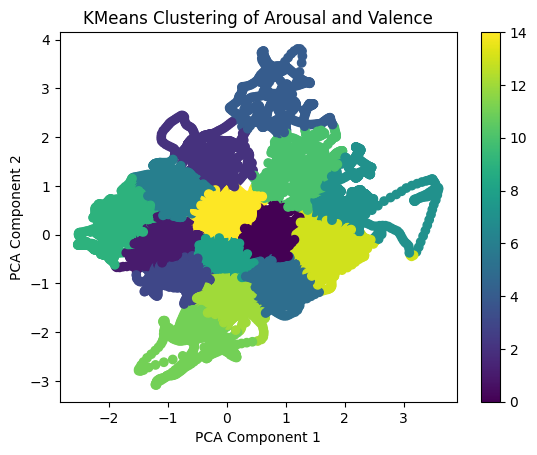


Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.98      0.98       801
           1       1.00      0.99      0.99       438
           2       0.99      0.99      0.99      1181
           3       0.80      0.98      0.88       269
           4       0.99      1.00      0.99       261
           5       0.98      0.97      0.97       551
           6       0.99      1.00      0.99      1092
           7       0.99      0.99      0.99       266
           8       0.97      0.98      0.98       898
           9       1.00      0.94      0.97       107
          10       0.99      0.97      0.98       208
          11       1.00      0.81      0.90       359
          12       0.98      1.00      0.99       614
          13       0.98      0.95      0.96       293
          14       0.98      0.99      0.99      1162

    accuracy                           0.98      8500
   macro avg       0.97      0.97      0.97      8500
we

In [13]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

train_df = []
for id in df_partitions[df_partitions.Proposal == 'train'].Id:
    df = get_subject_label(id)
    df['category'] = df.apply(categorize, axis=1)
    train_df.append(df)

train_df = pd.concat(train_df).drop(columns=['segment_id', 'timestamp'])

devel_df = []
for id in df_partitions[df_partitions.Proposal == 'devel'].Id:
    df = get_subject_label(id)
    df['category'] = df.apply(categorize, axis=1)
    devel_df.append(df)

devel_df = pd.concat(devel_df).drop(columns=['segment_id', 'timestamp'])

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(train_df[['arousal', 'valence']])

# Use PCA to reduce dimensions for visualization
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_scaled)

# Perform KMeans clustering
kmeans = KMeans(n_clusters=15, random_state=42)
train_df['cluster'] = kmeans.fit_predict(X_train_scaled)

# Visualize the clusters
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=train_df['cluster'], cmap='viridis')
plt.title('KMeans Clustering of Arousal and Valence')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar()
plt.show()

# Repeat the same process for devel_df
# Assuming you have devel_df loaded similarly to train_df
X_devel_scaled = scaler.transform(devel_df[['arousal', 'valence']])
devel_df['cluster'] = kmeans.predict(X_devel_scaled)

# Train the classifier on the new clusters
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Split the data into features and target
X_train = train_df[['arousal', 'valence']]
y_train = train_df['cluster']
X_devel = devel_df[['arousal', 'valence']]
y_devel = devel_df['cluster']

# Train a Random Forest classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Predict on the development set
y_pred = clf.predict(X_devel)

# Evaluate the model
print("\nClassification Report:")
print(classification_report(y_devel, y_pred))
print("\nAccuracy Score:")
print(accuracy_score(y_devel, y_pred))
